In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import model_eval

sns.set(color_codes=True)

%matplotlib inline

In [2]:
products = pd.read_csv("amazon_baby_products.csv")

In [3]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


## Remove empty reviews

In [4]:
empty = products[products.review.isnull()]

In [5]:
len(empty)

829

In [6]:
products = products.dropna()

In [7]:
len(products)

182384

## Create Sentiment indicator

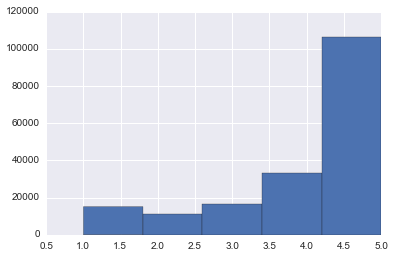

In [8]:
products.rating.hist(bins=5)

### Take out the 3 star reviews

In [9]:
reviews = products[products['rating'] != 3]

### 4 & 5 star reviews are considered positive in sentiment

In [10]:
reviews.loc[:, 'sentiment'] = reviews['rating'] >= 4

In [11]:
reviews.groupby('sentiment').count()

,name,review,rating
sentiment,,,
False,26361,26361,26361
True,139318,139318,139318


In [12]:
print '% of positive reviews:', reviews[reviews.sentiment == True].review.count()*1.0000/reviews.review.count()*1.0000

% of positive reviews: 0.840891120782


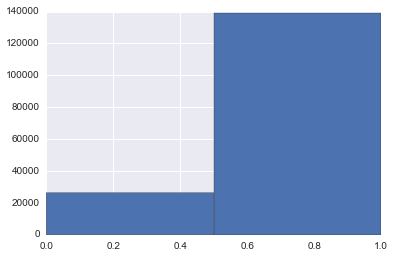

In [13]:
reviews.sentiment.hist(bins=2)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
count_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = "english",   \
#                              max_features = 30000 \
                           ) 

## Set up X & y

In [16]:
X = reviews.review

In [17]:
y = reviews.sentiment

In [18]:
print 'X\t',X.shape
print 'y\t',y.shape

X	(165679,)
y	(165679,)


## Logistic Classifier

In [19]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [20]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)

### Train/Test Split

In [22]:
# split at 80/20 to match example from class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print 'X_train\t',X_train.shape
print 'X_test\t',X_test.shape
print 'y_train\t',y_train.shape
print 'y_test\t',y_test.shape

X_train	(132543,)
X_test	(33136,)
y_train	(132543,)
y_test	(33136,)


## Vectorize Words into Bag of Words for each split

In [26]:
X_train_count = count_vec.fit_transform(X_train)

In [27]:
# only call transform on the test data, since we created the vocabulary on the training data
X_test_count = count_vec.transform(X_test)

In [ ]:
print 'X_train_count\t',X_train_count.shape
print 'X_test_count\t',X_test_count.shape

## Train

In [ ]:
#fit on training data
model = logreg.fit(X_train_count, y_train)

## Predict

In [ ]:
y_pred = logreg.predict(X_test_count)

In [ ]:
y_pred

## Evaluate

In [ ]:
print "Accuracy:\t", metrics.accuracy_score(y_test, y_pred) 
# print 'MSE\t\t', ((y_pred - y_test) ** 2).mean()
# print 'RMSE\t\t', np.sqrt( ((y_pred - y_test) ** 2).mean())

In [ ]:
y_scores = model.decision_function(X_test_count)
y_probs = model.predict_proba(X_test_count)

In [ ]:
cm, cm_norm = model_eval.confusion_matrix(y_test, y_pred)

In [ ]:
pd.DataFrame(cm)

In [ ]:
pd.DataFrame(cm_norm)

In [ ]:
model_eval.plot_confusion_matrix(cm_norm, labels=["Bad", "Good"])

In [ ]:
fpr, tpr, thres, auc = model_eval.plot_roc(y_test, y_scores)

In [ ]:
# cross_val_scores = model_eval.cross_validation(logreg, X, y, n_jobs=4)

In [ ]:
# print "min score:", cross_val_scores.min()
# print "max score:", cross_val_scores.max()

## Let's set up a pipeline
Makes the chaining of vectorization and fitting a little easier (maybe?)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
# from sklearn.neighbors import KNeighborsClassifier --sucks
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# clf = logreg
# clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf = DecisionTreeClassifier()

text_clf = Pipeline([('vect', count_vec),
                     ('clf', clf)
                     ])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print 'X_train\t',X_train.shape
print 'X_test\t',X_test.shape
print 'y_train\t',y_train.shape
print 'y_test\t',y_test.shape

text_clf = text_clf.fit(X_train, y_train)

In [ ]:
y_pred = text_clf.predict(X_test)

In [ ]:
np.mean(y_pred == y_test)  

In [ ]:
y_scores = text_clf.decision_function(X_test)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

In [ ]:
cm, cm_norm = model_eval.confusion_matrix(y_test, y_pred)

In [ ]:
pd.DataFrame(cm_norm)

In [ ]:
model_eval.plot_confusion_matrix(cm_norm, labels=["Negative", "Positive"])

In [ ]:
model_eval.plot_roc(y_test, y_scores)

## XGBoost Test

In [23]:
import xgboost as xgb

In [25]:
type(X_train)

pandas.core.series.Series

In [36]:
d_xtrain = xgb.DMatrix(X_train_count, label=y_train)
d_xtest = xgb.DMatrix(X_test_count, label=y_test)
d_ytrain = xgb.DMatrix(y_train)
d_ytest = xgb.DMatrix(y_test)

In [37]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 2
watchlist  = [(d_xtest,'eval'), (d_xtrain,'train')]

In [35]:
labels

array([], dtype=float32)

In [38]:
bst = xgb.train(param, d_xtrain, num_round, watchlist)

[0]	eval-error:0.144676	train-error:0.144270
[1]	eval-error:0.138580	train-error:0.138589


In [43]:
dx_pred = bst.predict(d_xtest)

In [44]:
dx_pred

array([ 0.83708024,  0.83708024,  0.92214864, ...,  0.83708024,
        0.92214864,  0.83708024], dtype=float32)

In [45]:
np.mean(dx_pred == y_test)  

0.0